<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Refactor-ANOVA-code-from-question-1b" data-toc-modified-id="Refactor-ANOVA-code-from-question-1b-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Refactor ANOVA code from question 1b</a></span></li><li><span><a href="#Refactor-Revenue-Code" data-toc-modified-id="Refactor-Revenue-Code-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Refactor Revenue Code</a></span></li></ul></div>

In [1]:
import sqlite3 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from numpy import std,mean,sqrt
from scipy import stats
import scipy.stats as st
import seaborn as sns
import datetime
%matplotlib inline

In [2]:
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

## Refactor ANOVA code from question 1b
In section 7 of my project (see juptyr notebook), I created a dataframe called anova that had the quantity of a product ordered and the discount.  Below is my additional work to refactor the code and be less DRY.

In [3]:
c.execute("""SELECT quantity, discount
             FROM orderdetail AS O
             JOIN product AS P
             ON (O.productid = P.id)
             ;""")
anova = pd.DataFrame(c.fetchall())
anova.columns = [x[0] for x in c.description]
anova.head(10)

,Quantity,Discount
0,12,0.00
1,10,0.00
2,5,0.00
3,9,0.00
4,40,0.00
5,10,0.00
6,35,0.15
7,15,0.15
8,6,0.05
9,15,0.05


In [4]:
# remember, Capital D on Discount, not lower d!
anova.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [5]:
# I was using '' !  and it was not making the change
#regex = regular expression, like  a wildcard 

# In the project I just grouped 1%,2%,3%,4% and 6%, but below I merely changed them since there so few 
anova.Discount.replace(0.01,0.05,inplace = True,regex = True)
anova.Discount.replace(0.02,0.05,inplace = True,regex = True)
anova.Discount.replace(0.03,0.05,inplace = True,regex = True)
anova.Discount.replace(0.04,0.05,inplace = True,regex = True)
anova.Discount.replace(0.06,0.05,inplace = True,regex = True)

In [6]:
anova.Discount.value_counts()

0.00    1317
0.05     193
0.10     173
0.20     161
0.15     157
0.25     154
Name: Discount, dtype: int64

In [7]:
#Tried this method, but kept getting error: "'float' object has no attribute 'replace'"
#anova.Discount = anova.Discount.map(lambda x: x.replace(0.03, 0.05))

# Not really an "if" conditional, more of a where.  
# anova.Discount = anova.Discount.map(lambda x: 0.05 if ('Discount' == 0.03))

# What other option is there with map and lambda?

In [8]:
# Code from project

# def transform_zero(df):
#     if df['Discount'] == 0.00:
#         return 1
#     else:
#         return 0
    
# anova['Zero'] = anova.apply(transform_zero, axis=1)

In [9]:
# One method to transform anova dataframe
# Pass in the discount using args, this would have been more complicated if there was a range of discounts
# like 1 to 5% in one group.

def transform(df,discount):
    if df['Discount'] == discount:
        return 1
    else:
        return 0
    
#anova['Zero'] = anova.apply(transform(anova,0.00), axis=1)


#anova['zero'] = anova.Discount.map(lambda x: x if (x == 0) return 1 else 0)

# THIS WORKED
# googled "how do i pass in a value for a method using apply in pandas"
# The pandas.series.apply documentation was first

anova['Zero'] = anova.apply(transform, args=(0.00,), axis=1)
anova['Five'] = anova.apply(transform, args=(0.05,), axis=1)
anova['Ten'] = anova.apply(transform, args=(0.10,), axis=1)
anova['Fifteen'] = anova.apply(transform, args=(0.15,), axis=1)
anova['Twenty'] = anova.apply(transform, args=(0.20,), axis=1)
anova['TwentyFive'] = anova.apply(transform, args=(0.25,), axis=1)

In [10]:
anova.head()

,Quantity,Discount,Zero,Five,Ten,Fifteen,Twenty,TwentyFive
0,12,0.0,1,0,0,0,0,0
1,10,0.0,1,0,0,0,0,0
2,5,0.0,1,0,0,0,0,0
3,9,0.0,1,0,0,0,0,0
4,40,0.0,1,0,0,0,0,0


## Refactor Revenue Code 
Try to refactor so I can find revenue by date with a method

In [11]:
# Original code from the project

c.execute("""SELECT SUM(unitPrice*quantity) AS sale, orderdate
             FROM orderdetail
             JOIN 'order' as o
             ON orderdetail.orderid = o.id
             WHERE orderdate between '2014-04-01' and '2014-04-31'
             ;""")


df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]
df

,sale,OrderDate
0,134630.56,2014-04-30


In [12]:
c.execute("""SELECT unitPrice,quantity, orderdate
             FROM orderdetail
             JOIN 'order' as o
             ON orderdetail.orderid = o.id
             ORDER BY orderdate
             ;""")

df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]
df.head()

,UnitPrice,Quantity,OrderDate
0,14.0,12,2012-07-04
1,9.8,10,2012-07-04
2,34.8,5,2012-07-04
3,18.6,9,2012-07-05
4,42.4,40,2012-07-05


In [13]:
df.info()
#orderdate is an object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 3 columns):
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
OrderDate    2155 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 50.6+ KB


In [14]:
# df['year'] = pd.DatetimeIndex(df['OrderDate']).year
# df['month'] = pd.DatetimeIndex(df['OrderDate']).month
# df.head()

In [15]:
# df['OrderDate'].astype(str)
# df.info()
df['OrderDate'] =  pd.to_datetime(df['OrderDate'])
df = df.set_index(['OrderDate'])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2155 entries, 2012-07-04 to 2014-05-06
Data columns (total 2 columns):
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
dtypes: float64(1), int64(1)
memory usage: 50.5 KB


In [16]:
# df['month_year'] = pd.to_datetime(df['OrderDate']).dt.to_period('M')
# # df = df.set_index(['OrderDate'])
# df.info()

In [17]:
# when I tried df.revenue, it did not work, but did when I used quotes and square brackets 

df['revenue'] = df['UnitPrice'] * df['Quantity']
# df = pd.DataFrame(c.fetchall())
# df.columns = [x[0] for x in c.description]
df.head()

,UnitPrice,Quantity,revenue
OrderDate,,,
2012-07-04,14.0,12,168.0
2012-07-04,9.8,10,98.0
2012-07-04,34.8,5,174.0
2012-07-05,18.6,9,167.4
2012-07-05,42.4,40,1696.0


In [18]:
# mask = (df['OrderDate'] > '2012-7-4' & (df['OrderDate'] <= '2012-7-31')
# df.loc[mask]



# def get_revenue(df):
#     sum = 0
# #     mask = (df['OrderDate'] > start & (df['OrderDate'] <= end)
# #     print(df.loc[mask])
            
#     for row in df:
#         if df[(df['OrderDate'] >= '2012-7-1') & (df['OrderDate'] <= '2012-7-31')]:
#             sum += df['revenue']
#     return sum   

# def get_revenue(df,a):
#     sum = 0
    
#     for row in a:
#         sum += df['revenue']
#     return sum  

In [19]:
# a = df.loc['2012-7-4':'2012-7-31']
# print(a)

# sum= df.apply(get_revenue,args=a, axis=1)
# print(sum)
# a = df.apply(get_revenue, args=(2012-7-4,2012-7-31))
# anova['Zero'] = anova.apply(transform, args=(0.00,), axis=1)
# a = get_revenue(df)
# print(a)

In [20]:
# look at interactions readme
# did not work
#data= df[df['OrderDate'] >= '2012-07-04' and df['OrderDate'] <= '2012-07-31']

# divide the dataframe up to months?
#df[0:15]

In [21]:
# https://chrisalbon.com/python/data_wrangling/pandas_group_data_by_time/

df_resampled = df.resample('M').sum()
df_resampled

,UnitPrice,Quantity,revenue
OrderDate,,,
2012-07-31,1213.20,1462,30192.10
2012-08-31,1487.50,1322,26609.40
2012-09-30,1340.60,1124,27636.00
2012-10-31,1604.90,1738,41203.60
2012-11-30,1834.70,1735,49704.00
2012-12-31,1929.30,2200,50953.40
2013-01-31,2081.30,2401,66692.80
2013-02-28,1507.70,2132,41207.20
2013-03-31,1670.10,1770,39979.90


In [22]:
# df_resampled = df.set_index('OrderDate').resample('M').sum().reset_index()
# df_resampled.info()

In [27]:
df_resampled = df_resampled.truncate(after='2014-04-30')
df_resampled

,UnitPrice,Quantity,revenue
OrderDate,,,
2012-07-31,1213.20,1462,30192.10
2012-08-31,1487.50,1322,26609.40
2012-09-30,1340.60,1124,27636.00
2012-10-31,1604.90,1738,41203.60
2012-11-30,1834.70,1735,49704.00
2012-12-31,1929.30,2200,50953.40
2013-01-31,2081.30,2401,66692.80
2013-02-28,1507.70,2132,41207.20
2013-03-31,1670.10,1770,39979.90


In [23]:
# df_resampled['month_year'] = pd.to_datetime(df_resampled['OrderDate']).dt.to_period('M')
#df = df.set_index(['OrderDate'])
# df_resampled.info()

In [24]:
# x = df_resampled.index
# y = df_resampled['revenue']
# ax = df.plot.bar(x=x,y=y)

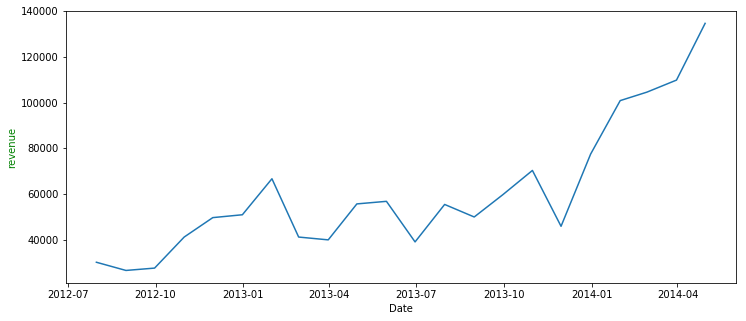

In [28]:
# http://benalexkeen.com/resampling-time-series-data-with-pandas/

fig, ax1 = plt.subplots()
plt.rcParams['figure.figsize'] = 15,15

#ax2 = ax1.twinx()
ax1.plot(df_resampled.index, df_resampled['revenue'])
#ax2.plot(weekly_summary.index, weekly_summary['distance'], 'b-')

ax1.set_xlabel('Date')
ax1.set_ylabel('revenue', color='g')
#ax2.set_ylabel('Distance', color='b')

plt.show()